# Исследование рынка заведений общественного питания Москвы

**Заказчик:** для потенциального инвестора.

**Входные данные:**
- список московских предприятий общественного питания (открытый источник);
- данные о московских улицах (открытый источник).

**Цель проекта:** Анализ текущего положения на рынке общественного питания Москвы с целью открытия собственного инновационного кибер-кафе.

**Задачи проекта:**

- подготовить рекомендации о виде заведения, количестве посадочных мест, районе расположения;
- оценить возможность развития сети;
- определить потенциальные риски данного исследования, возможности их устранения;  
- дать рекомендации по дальнейшему развитию данного исследования.

---
## Начальная подготовка

In [1]:
# %matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# ПОЛЕЗНЫЕ ФУНКЦИИ

#--------------------------------------------------------------------
# загрузка данных

def df_read_csv(path):
    
    try:
        return pd.read_csv(path)
    except Exception:
        print('Ошибка при загрузке файла')


#--------------------------------------------------------------------
# определение имени таблицы

def df_name(df):
    return [name for name in globals() if globals()[name] is df][0]


#--------------------------------------------------------------------
# вывод таблиц с выравниванием полей типа obect по левому краю
# !!! зависает, если выводимая таблица не умещается в установленный лимит строк !!!

def display_left(df):
    
    object_type_fields = []
    for column in df.select_dtypes('object').columns:   # составление списка полей типа object
        object_type_fields.append(column)
    
    # выравнивание значений
    left_aligned_df = df.style.set_properties(
                                              subset=object_type_fields,
                                              **{'text-align': 'left'}
                                             )
    # выравнивание заголовков
    left_aligned_df = left_aligned_df.set_table_styles(
                                                       [dict(subset=object_type_fields,
                                                             selector='th',
                                                             props=[('text-align', 'left')]
                                                            )
                                                       ]
                                                      )
    return display(left_aligned_df)


#--------------------------------------------------------------------
# первичная информация о таблице

def basic_info(df, sample='sample', qnty=10):

    print(font.BOLD + '\n'*2 + f'таблица {df_name(df)}' + font.END, end=' ' + theme_char*20 + '\n\n')

    # метод info()
    print(df.info())

    # несколько записей
    if sample == 'sample':
        display_left(df.sample(qnty))
    elif sample == 'head':
        display_left(df.head(qnty))
    else:
        display_left(df.tail(qnty))
    
    # метод describe()
    print(df.describe(), '\n')
    print(df.describe(exclude=['int', 'uint', 'float']), '\n')


#--------------------------------------------------------------------
# перевод значений полей типа object в нижний регистр

def object_fields_lower(df):  # dataframe
    
    for i in range(len(df.dtypes)):
        if df.dtypes[i] == 'object':
            df[df.columns[i]] = df[df.columns[i]].str.lower()


#--------------------------------------------------------------------
# числовые значения для вертикальных bar-графиков
# доработать до универсальноой (+ горизонтальные)

def bar_annotate(ax, decimals=0):
    
    max_height = 0
    for p in ax.patches:
        if p.get_height() > max_height:
            max_height = p.get_height()
    
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + max_height*0.01
        value = f'{p.get_height():n}'
#         value = f'{p.get_height():.{decimals}f}'  # либо так (тест)
        ax.text(_x, _y, value, ha="center")

In [4]:
# ДЛЯ ОФОРМЛЕНИЯ

#--------------------------------------------------------------------------
# для свободного пространства (пустые строки)

def space(num=1):
    print('\n' * num)
    
#--------------------------------------------------------------------------
# для украшения и разнообразия: ✺ ★ ☆ ✦ ✻ ⚛ ∻ ⋰ 🍴

theme_char = '🍴 '

#--------------------------------------------------------------------------
# для оформления текста
class font:
    BOLD = "\033[1m"
    FAINT = "\033[2m"
    ITALIC = "\033[3m"
    END = "\033[0m"

### Настройки

In [5]:
# стиль графиков
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plot_dpi = 50                # dpi для рендеринга графиков

# цвета для графиков
color_chn = 'deepskyblue'     # для обозначения сетевых заведений
color_sng = 'darkturquoise'   # для обозначения одиночных заведений
color_bsc = 'skyblue'         # для всех остальных графиков

# внешний вид
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 1)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 100)

### Загрузка данных

In [6]:
# входные данные
data = df_read_csv('datasets/rest_data.csv')

# внешние данные об улицах Москвы
street_DB = df_read_csv('https://frs.noosphere.ru/xmlui/bitstream/handle/20.500.11925/714058/mosgaz-streets.csv?sequence=1')

---
## Проверка и подготовка данных

### Общая информация о входных данных

In [7]:
basic_info(data)
basic_info(street_DB)



таблица data 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 🍴 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None


,id,object_name,chain,object_type,address,number
439,152448,Рюмочная Бухучет,нет,кафе,"город Москва, Большая Сухаревская площадь, дом 16/18, строение 1",40
1458,24106,КУЛИНАРИЯ,нет,магазин (отдел кулинарии),"город Москва, Ангелов переулок, дом 7",1
917,124608,Бургер Кинг,да,предприятие быстрого обслуживания,"город Москва, улица Большая Полянка, дом 28, корпус 1",45
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
7343,28502,Столовая (налоговая),нет,столовая,"город Москва, Большая Тульская улица, дом 15",100
11249,177199,Дан Кафе,нет,предприятие быстрого обслуживания,"город Москва, Большая Семёновская улица, дом 16",20
9684,168909,Кафетерий,нет,кафетерий,"город Москва, Ореховый бульвар, дом 53, корпус 2",0
3950,28813,Столовая при ШК. 1310 (796),нет,столовая,"город Москва, Перовская улица, дом 44Б",270
1221,29248,Столовая ГОУ 436,нет,столовая,"город Москва, Ферганский проезд, дом 7, корпус 1",200
6700,74955,Теремок,да,закусочная,"город Москва, Осенний бульвар, дом 12",38


             id   number
count   15366.0  15366.0
mean   119720.1     59.5
std     73036.1     74.7
min       838.0      0.0
25%     28524.0     12.0
50%    144974.5     40.0
75%    184262.2     80.0
max    223439.0   1700.0 

              id object_name  chain object_type  \
count    15366.0       15366  15366       15366   
unique       NaN       10393      2           9   
top          NaN    Столовая    нет        кафе   
freq         NaN         267  12398        6099   
mean    119720.1         NaN    NaN         NaN   
std      73036.1         NaN    NaN         NaN   
min        838.0         NaN    NaN         NaN   
25%      28524.0         NaN    NaN         NaN   
50%     144974.5         NaN    NaN         NaN   
75%     184262.2         NaN    NaN         NaN   
max     223439.0         NaN    NaN         NaN   

                                       address   number  
count                                    15366  15366.0  
unique                                    91

,streetname,areaid,okrug,area
3366,Домодедовская улица,106,ЮАО,Район Орехово-Борисово Южное
3352,Криворожский проезд,104,ЮАО,Нагорный район
1373,Верейская улица,41,ЗАО,Можайский Район
709,Хабаровская улица,25,ВАО,Район Гольяново
1172,Старослободский переулок,26,ВАО,Район Сокольники
2130,2-й Хуторской переулок,65,САО,Савеловский район
3999,Варшавское шоссе,130,ЮЗАО,Район Северное Бутово
962,11-я Парковая улица,35,ВАО,Район Северное Измайлово
2001,1-й Магистральный тупик,69,САО,Хорошевский район
3215,2-я Самаринская улица,98,ЮАО,Даниловский район


       areaid
count  4398.0
mean     59.2
std      38.5
min      12.0
25%      20.0
50%      51.0
75%      93.0
max     134.0 

                             streetname  areaid okrug            area
count                              4398  4398.0  4398            4398
unique                             3604     NaN    10             123
top     Московская Кольцевая Автодорога     NaN   ЦАО  Тверской район
freq                                 42     NaN  1200             179
mean                                NaN    59.2   NaN             NaN
std                                 NaN    38.5   NaN             NaN
min                                 NaN    12.0   NaN             NaN
25%                                 NaN    20.0   NaN             NaN
50%                                 NaN    51.0   NaN             NaN
75%                                 NaN    93.0   NaN             NaN
max                                 NaN   134.0   NaN             NaN 



### Базовая подготовка

In [8]:
# входные данные

# переименование полей
data = data.rename(columns={'object_name':'name', 'object_type':'type', 'number':'seats'})

# перевод значений полей типа object в нижний регистр
object_fields_lower(data)

# замена букв "ё"
data.name = data.name.str.replace('ё', 'е')
data.address = data.address.str.replace('ё', 'е')

display_left(data.sample())

,id,name,chain,type,address,seats
14460,205806,пиво и гриль,нет,предприятие быстрого обслуживания,"город москва, локомотивный проезд, дом 4",5


In [9]:
# внешние данные

# переименование полей
street_DB = street_DB.rename(columns={'streetname':'street'})

# перевод значений полей типа object в нижний регистр
object_fields_lower(street_DB)

# замена букв "ё"
street_DB.name = street_DB.street.str.replace('ё', 'е')
street_DB.address = street_DB.area.str.replace('ё', 'е')

display_left(street_DB.sample(1))

,street,areaid,okrug,area
1743,школьная улица,51,зеленоград,район крюково


### Проверка на полные дубликаты

In [10]:
# проверка на дубликаты

def duplicated_test(df):
    print('\n', f'количество полных дубликатов в таблице {df_name(df)}: {df.duplicated().sum()}', '\n')
    
duplicated_test(data)


 количество полных дубликатов в таблице data: 0 



>Полных дубликатов не обнаружено

### Поиск неявных дубликатов

In [11]:
# проверка на дубликаты по сокращенному количеству полей
# для начала - исключено поле id

data_cuted = data[['name', 'address', 'type', 'seats', 'chain']]
duplicated_test(data_cuted)

data_duplicated = data_cuted[data_cuted.duplicated(keep=False)].join(data[['id']], how='left')

display_left(data_duplicated.sort_values(['name', 'address', 'type', 'seats']).head(10))


 количество полных дубликатов в таблице data_cuted: 85 



,name,address,type,seats,chain,id
2869,laltro bosco,"город москва, улица петровка, дом 10",ресторан,145,нет,25031
13858,laltro bosco,"город москва, улица петровка, дом 10",ресторан,145,нет,209723
5058,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,20,нет,20019
5059,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,20,нет,20021
5067,lift,"город москва, багратионовский проезд, дом 7, корпус 3",кафе,10,нет,20023
5069,lift,"город москва, багратионовский проезд, дом 7, корпус 3",кафе,10,нет,20025
14843,sushi-make,"город москва, ярцевская улица, дом 19",предприятие быстрого обслуживания,0,нет,219509
14844,sushi-make,"город москва, ярцевская улица, дом 19",предприятие быстрого обслуживания,0,нет,219518
5761,алекс,"город москва, тихорецкий бульвар, владение 1, строение 2",кафе,45,нет,134323
5762,алекс,"город москва, тихорецкий бульвар, владение 1, строение 2",кафе,45,нет,134324


In [12]:
# удаление неявных дубликатов (различающихся только значением в поле id)

print('записей до удаления:', data.shape[0])
print('записей для удаления:', data_cuted[data_cuted.duplicated()].shape[0])
data = data[~data_cuted.duplicated()]
print('записей после удаления:', data.shape[0])

записей до удаления: 15366
записей для удаления: 85
записей после удаления: 15281


>Удалено 85 записей идентичных, за исключением id

In [13]:
# проверка на дубликаты по сокращенному количеству полей
# исключены поля id, seats и chain

data_cuted = data[['name', 'address', 'type']]
duplicated_test(data_cuted)


 количество полных дубликатов в таблице data_cuted: 99 



In [14]:
data_duplicated = data_cuted[data_cuted.duplicated(keep=False)].join(data[['seats', 'chain']], how='left')
display_left(data_duplicated.sort_values(['name', 'address', 'type']).head(20))

,name,address,type,seats,chain
8004,eat and talk,"город москва, улица воздвиженка, дом 4/7, строение 2",ресторан,80,нет
8005,eat and talk,"город москва, улица воздвиженка, дом 4/7, строение 2",ресторан,10,нет
6371,il patio,"город москва, манежная площадь, дом 1, строение 2",ресторан,89,нет
6372,il patio,"город москва, манежная площадь, дом 1, строение 2",ресторан,45,нет
5057,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,25,нет
5058,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,20,нет
5060,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,40,нет
5068,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,10,нет
12731,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,5,нет
12732,lift,"город москва, багратионовский проезд, дом 7, корпус 1",кафе,3,нет


>Данные содержат предполагаемые скрытые дубликаты. Подробнее — в выводе по разделу.

### Проверка и замена значений на более удобные

In [15]:
# проверка и замена значений в поле type на более удобные

display(data.type.value_counts())
data.type = data.type.mask(data.type == 'предприятие быстрого обслуживания', 'фастфуд')
data.type = data.type.mask(data.type == 'магазин (отдел кулинарии)', 'кулинария')
display(data.type.value_counts())

кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1897
бар                                   855
буфет                                 576
кафетерий                             395
закусочная                            348
магазин (отдел кулинарии)             273
Name: type, dtype: int64

кафе          6071
столовая      2584
ресторан      2282
фастфуд       1897
бар            855
буфет          576
кафетерий      395
закусочная     348
кулинария      273
Name: type, dtype: int64

In [16]:
# замена значений в поле chain на более удобные

data.chain = data.chain.mask(data.chain == 'да', 'сетевое')
data.chain = data.chain.mask(data.chain == 'нет', 'одиночное')
display(data.chain.value_counts())

одиночное    12317
сетевое       2964
Name: chain, dtype: int64

### Проверка на последовательные пробелы

In [17]:
# проверка на 2 пробела подряд в полях name и address

print(data.query('name.str.contains("\s{2}")').shape[0])
print(data.query('address.str.contains("\s{2}")').shape[0])

0
0


>Двойных пробелов нет.

### Проверка на наличие буквосочетания "москва"

In [18]:
# все ли адреса содержат слово "москва"?
# будем считать, что даже если не содержат, они относятся к Москве (либо каждый адрес проверять вручную)

space()
print('количество адресов, не содержащих слово "москва":',
      data[~data.address.str.contains('москва')].shape[0]
     )

display_left(data[~data.address.str.contains('москва')].head(5))
space()



количество адресов, не содержащих слово "москва": 71


,id,name,chain,type,address,seats
859,23601,буфет - гбоу сош № 64,одиночное,буфет,"партизанская улица, дом 30",100
860,23604,буфет - гбоу 60,одиночное,буфет,"партизанская улица, дом 30",100
1491,25349,ресторан «гранатовый сад»,одиночное,ресторан,"поречная улица, дом 5/14, строение 1",40
7691,132359,кафе «la carotte»,одиночное,кафе,"1-й нагатинский проезд, дом 10",198
7827,28214,роснефть (закрытое),одиночное,столовая,"софийская набережная, дом 26/1, строение 1",80


In [19]:
# добавление слова "москва" к тем записям, где оно отсутствует

data.address = data.address.mask(~data.address.str.contains('москва'), 'москва, ' + data.address)
display(data.iloc[[859, 860, 1491, 7691, 7827]])

,id,name,chain,type,address,seats
859,23601,буфет - гбоу сош № 64,одиночное,буфет,"москва, партизанская улица, дом 30",100
860,23604,буфет - гбоу 60,одиночное,буфет,"москва, партизанская улица, дом 30",100
1491,25349,ресторан «гранатовый сад»,одиночное,ресторан,"москва, поречная улица, дом 5/14, строение 1",40
7718,106130,yes pizza,одиночное,фастфуд,"город москва, кировоградская улица, дом 13а",25
7854,27780,столовая для персонала,одиночное,столовая,"город москва, улица петровка, дом 11",18


>Теперь все записи содержат слово "москва"

### Удаление пригородов из данных

In [20]:
# удаление пригородов из данных

data.address = data.address.str.replace('город москва', 'москва')  # слово "город" будет предшествовать только пригородам
delete_str = '\sгород\s|поселение\s|деревня\s|поселок\s'           # записи, содержащие эти выражения в поле address, будут удалены

space()
print('количество записей до удаления:', data.shape[0])
print('к удалению:', data.query('address.str.contains(@delete_str)').shape[0])
data = data.query('~address.str.contains(@delete_str)')
print('количество записей после удаления:', data.shape[0])

space()
print('контроль: улицы, содержащие буквосочетание "город", не удалены')
display(data.query('address.str.contains("город")').sample(5))



количество записей до удаления: 15281
к удалению: 827
количество записей после удаления: 14454


контроль: улицы, содержащие буквосочетание "город", не удалены


,id,name,chain,type,address,seats
7324,145553,столовая,одиночное,столовая,"москва, городская улица, дом 8",80
14727,212583,right hops,одиночное,бар,"москва, 2-я звенигородская улица, дом 12, строение 70",15
12352,199315,самса,одиночное,кафе,"москва, нижегородская улица, дом 80, корпус 1",28
764,25442,кафе «якитория»,сетевое,кафе,"москва, нижегородская улица, дом 2, корпус 1",106
10392,189215,кафе хинкальная,одиночное,кафе,"москва, нижегородская улица, дом 1а",40


>Пригороды удалены из данных

### Заведения с нулевым количеством мест

In [21]:
# доля заведений с нулевым количеством мест

id_zero = data.query('seats == 0').id.count()
id_total = data.id.count()

space()
print('доля заведений с нулевым количеством мест: {:.1%}'.format(id_zero / id_total))


# количество и доля заведений с нулевым количеством мест в зависимости от типа

zero = (
             pd.merge(
                     data.type.value_counts().reset_index(),
                     data.query('seats == 0').type.value_counts().reset_index(),
                     on='index',
                     suffixes=('_t','_z')
                    )
              .rename(columns={'index':'type','type_t':'total','type_z':'zero'})
            )

zero['zero_%'] = zero['zero'] / zero['total']

display(
        zero.sort_values('zero_%')
            .set_index('type')
            .style.background_gradient('Blues', subset='zero_%', high=1)
            .format({'zero_%': '{:.2%}'})
       )



доля заведений с нулевым количеством мест: 10.1%


,total,zero,zero_%
type,,,
столовая,2449,19,0.78%
ресторан,2189,39,1.78%
бар,826,28,3.39%
кафе,5702,275,4.82%
буфет,557,58,10.41%
кафетерий,365,105,28.77%
фастфуд,1798,650,36.15%
кулинария,251,126,50.20%
закусочная,317,163,51.42%


>Нулевое количество мест выраженно зависит от типа заведения. Оно больше у того типа, который может не иметь собственных посадочных мест. Можно предположить, что чаще заведение действительно не имеет собственных мест, а ноль вместо реального количества мест указывается нечасто.

In [22]:
# соотношение между одиночными / сетевыми заведениями

id_nonzero = data.query('seats != 0').groupby('chain').id.count()
id_zero = data.query('seats == 0').groupby('chain').id.count()

display(id_nonzero)
display(id_zero)

print('соотношение одиночные/сетевые с отличным от нуля количеством мест: {:.2f}'.format(id_nonzero[0] / id_nonzero[1]))
print('соотношение одиночные/сетевые с нулевым количеством мест : {:.2f}'.format(id_zero[0] / id_zero[1]))

chain
одиночное    10403
сетевое       2588
Name: id, dtype: int64

chain
одиночное    1230
сетевое       233
Name: id, dtype: int64

соотношение одиночные/сетевые с отличным от нуля количеством мест: 4.02
соотношение одиночные/сетевые с нулевым количеством мест : 5.28


>Нулевое количество мест встречается чаще среди одиночных заведений примерно на 31%.

In [23]:
# более детально о ресторанах с нулевым количеством мест

display_left(data.query('seats == 0 and type == "ресторан"'))

,id,name,chain,type,address,seats
4490,152298,фудмаркет. яшечкина,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4491,152299,фудмаркет. грачева,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4492,152305,фудмаркет. шапиро,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4493,152307,фудмаркет. салпагарова,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4501,152255,фудмаркет.швыдкой,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4502,152222,фудмаркет.паритова,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4503,152224,фудмаркет. рогачикова,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
4504,152216,фудмаркет. галичкин,одиночное,ресторан,"москва, улица новый арбат, дом 21",0
6113,27193,максимальный ресторан,одиночное,ресторан,"москва, профсоюзная улица, дом 61а",0
6117,89735,макдоналдс,сетевое,ресторан,"москва, профсоюзная улица, дом 61а",0


>Мое представление, что такое ресторан, пошатнулось.

In [24]:
# ... и столовых с нулевым количеством мест

display_left(data.query('seats == 0 and type == "столовая"'))

,id,name,chain,type,address,seats
206,150836,гбоу школа №1468,одиночное,столовая,"москва, волгоградский проспект, дом 17, строение 1",0
2101,29844,вкусный выбор,одиночное,столовая,"москва, аллея жемчуговой, дом 1а",0
2130,152335,пищеблок ( закрытое),одиночное,столовая,"москва, ленинский проспект, дом 8, корпус 23",0
2675,23137,самса хаус,одиночное,столовая,"москва, широкая улица, дом 12",0
4176,150827,гбоу школа №498,одиночное,столовая,"москва, улица малые каменщики, дом 18",0
4701,150840,гбоу школа №2104,одиночное,столовая,"москва, николоямская улица, дом 15",0
4736,150823,гбоу школа №480 им.в.в. талалихина,одиночное,столовая,"москва, стройковская улица, дом 5",0
4737,150838,гбоу школа №1468,одиночное,столовая,"москва, рабочая улица, дом 10",0
4739,150833,гбоу школа №1468,одиночное,столовая,"москва, рабочая улица, дом 35, корпус 2",0
4740,150835,гбоу школа №1468,одиночное,столовая,"москва, вековая улица, дом 10",0


>В данных присутствует большое количество заведений с нулевым количеством мест.  
Присутствуют заведения не для общего пользования (например, школьные столовые или с явным указанием "закрытое").  
Подробнее — в выводе по разделу.

In [25]:
# к какому типу причисляют себя некоторые сетевые заведения

space()
display('Макдоналдс', data.query('name == "макдоналдс"').type.value_counts().to_frame())
space()
display('Бургер Кинг', data.query('name == "бургер кинг"').type.value_counts().to_frame())

'Макдоналдс'

,type
фастфуд,98
ресторан,22
кафе,21


'Бургер Кинг'

,type
фастфуд,88
кафе,22
ресторан,11
закусочная,5
бар,1


>По старой, но вряд ли доброй традиции, сеть "Макдональдс" называла свои заведения ресторанами. Эта выборка показывает, что тип заведения в данных может не соответствовать реальности либо имеет расплывчатые критерии.  Подробнее — в выводе по разделу.

### Выделение улицы из адреса

In [26]:
# проверка: всегда ли после выражения "Москва" следует символ ","

space()
if data.query('address.str.contains("москва[^,]")').shape[0] == 0:
    print('все в порядке: после выражения "москва" всегда следует запятая')
else:
    print('проблема: другой символ!')


# проверка: всегда ли после выражения "Москва," следует пробел

if data.query('address.str.contains("москва,[^\s]")').shape[0] == 0:
    print('все в порядке: после выражения "москва," всегда следует пробел')
else:
    print('проблема: другой символ!')
space()




все в порядке: после выражения "москва" всегда следует запятая
все в порядке: после выражения "москва," всегда следует пробел




In [27]:
# выделение улицы из адреса,
# исходя из предположений:  1) все адреса содержат выражение "москва"
#                           2) части адреса (город, улица, дом) разделены запятой с одним пробелом

streets_list = []

for street in data['address']:  
    start = street.find('москва, ') + 8        # город закончился, началась улица
    end = street.find(',', start)              # улица закончилась
    streets_list.append(street[start : end])

data['street'] = ""                            # для последующего контроля
data['street'] = streets_list

space()
display_left(data[['name', 'address', 'street']].sample(5))
space()

,name,address,street
2742,чешская пивная козловица,"москва, улица сретенка, дом 4",улица сретенка
1453,столовая при пансионате «коньково» для ветеранов войны,"москва, профсоюзная улица, дом 140, корпус 6",профсоюзная улица
6376,шоколадница,"москва, манежная площадь, дом 1, строение 2",манежная площадь
9910,селфипицца,"москва, улица декабристов, дом 12",улица декабристов
3862,тд гум «фестивальное» «япония»,"москва, красная площадь, дом 3",красная площадь


In [28]:
# проверка: все записи должны быть обработаны

space()
if data.query('street == ""').shape[0] == 0:
    print('все записи были обработаны')
else:
    print('есть необработанные записи - проблема!')



все записи были обработаны


>замеченные проблемы:  
>- ошибочные названия (например, "улица мичуринский проспект";  
>- изредка может отсутствовать запятая между улицей и домом.

In [29]:
# добавление ко входным данным информации о районе

data = pd.merge(
                data,
                street_DB[['street', 'area']],
                on='street',
                how='left'
               )

# представление информации о соответствии улица-район в более компактном виде

data.area = data.area + ' | '
data = (
        data
        .groupby(['id', 'name', 'type', 'chain', 'seats', 'address', 'street'])
        .agg({'area':'sum'})  # можно использовать функцию set, но вариант с функцией sum показался
        .reset_index()        # более красивым (set пригодится, если потребуется дальнейшая обработка)
       )
data.area = data.area.mask(data.area == 0, '')  # случается, что улицы нет во внешней БД
data.area = '| ' + data.area

display_left(data.sample(5))

,id,name,type,chain,seats,address,street,area
2652,26295,русское подворье,ресторан,одиночное,98,"москва, симферопольский бульвар, дом 16, корпус 1",симферопольский бульвар,| нагорный район | район зюзино |
14100,220571,kfc,фастфуд,сетевое,35,"москва, щукинская улица, дом 42",щукинская улица,| район щукино |
5185,74056,столовая бц интеграл,столовая,одиночное,180,"москва, проезд завода серп и молот, дом 10",проезд завода серп и молот,| район лефортово |
7763,151147,суши wok,кулинария,сетевое,6,"москва, чечерский проезд, дом 56, корпус 1",чечерский проезд,|
6795,137553,кальянная mr. mishka,бар,одиночное,30,"москва, улица сретенка, дом 27, строение 1",улица сретенка,| красносельский район | мещанский район |


<a id="id_1_11"></a>
### Вывод 

Быстрая проверка не выявила проблем во входных данных.

При более внимательном осмотре выяснилось следующее.

1. Данные содержат скрытые дубликаты.  
    - Некоторые заведения отличаются лишь значением id.  
    - Ряд заведений имеют идентичные названия, адрес и тип, но разное (часто близкое) количество мест. Это могут быть как действительно отдельные заведения, так и одно и то же заведение, имеющее несколько залов. Возможно, что одни и те же заведения попали в список несколько раз: по отдельности каждый зал и как сумма всех залов (например, кафе "lift": 10+20=30). Возможно, заведения расширялись/сужались, и в список попали более одного раза со старым и обновленным количеством мест.  
    - Некоторые заведения имеют идентичные названия и адрес, но различаются типом. Не исключено, что они представляют собой целостное заведение и разделены внутри на зоны (например, барная стойка в ресторане). Возможно, стоит их объединить, а количество мест просуммировать;
    - Есть заведения с одинаковыми адресами и количеством мест, с похожими, но все же разными названиями (например, "буфет - гбоу сош № 64" и "буфет - гбоу сош 60"). Это может быть одно и то же заведение.
1. Есть адреса, в которых не указано, что они находятся в Москве. Предполагаем, что все они московские, иначе необходимо проверять их вручную.
1. Часть адресов находится в пригородах. Предположительно, данные о заведениях из пригородов не соответствуют цели данного исследования.
1. Большое количество заведений, для которых указано нулевое количество посадочных мест.  
Количество мест может быть нулевым, если заведение не имеет собственных посадочных мест (например, расположено на фудкорте), либо не имеет определенного количества мест (например, в школе). Количество неуказанных (нулевых) мест выраженно зависит от типа заведения: нулей больше среди тех типов заведений, у которых действительно может не быть собственных мест.
Предположительно, количество записей, где нулевое количество мест указано ввиду отсутствия информации, невелико и существенно не повлияет на результат анализа.
1. В данном списке присутствуют заведения не для общего пользования (например, школьные столовые или закрытые заведения для сотрудников). Учитывая, что исследование ведется с целью открытия коммерческого заведения, присутствие закрытых заведений может внести искажения в результат анализа.
1. На примерах "ресторанов" "ИП будкин", сетей "Макдональдс" и "Бургер Кинг" видно, что тип заведения может не соответствовать реальности либо имеет расплывчатые критерии. Количество таких несоответствий в данных неизвестно, их может быть много, как и неверно указанное количество мест. Возможно, стоит провести ручную проверку по некоторой выборке, чтобы оценить точность входных данных.
1. Некоторые заведения обозначены фамилией владельца. Не исключено, что какие-то из них также имеют собственное имя, и потому могли попасть в данные дважды.

**Итог**

1. Удалено некоторое количество неявных дубликатов.
1. Добавлено слово "москва" к тем адресам, где его не было.
1. Удалены записи с адресами в пригородах.
1. Добавлены данные о районах, через которые проходит улица.
1. Заведения с нулевым количеством мест оставлены как есть. Большая часть требует трудоемкой ручной проверки. Удаление может негативно повлиять на результат. В тех случаях, когда анализ чувствителен к количеству мест, можно делать два расчета: с учетом всех заведений и без учета заведений с нулевым количеством мест.

## Анализ данных

<a id="id_2_1"></a>
### Соотношение видов объектов общественного питания по количеству

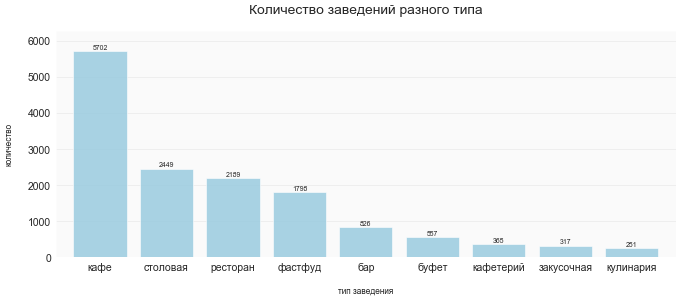

,id_count,part_%
type,,
кафе,5702,39.4%
столовая,2449,16.9%
ресторан,2189,15.1%
фастфуд,1798,12.4%
бар,826,5.7%
буфет,557,3.9%
кафетерий,365,2.5%
закусочная,317,2.2%
кулинария,251,1.7%


In [30]:
# подготовка данных

df = (
      data
      .groupby('type')
      .id.count()
      .reset_index()
      .rename(columns={'id':'id_count'})
      .sort_values('id_count', ascending=False)
     )

# график

fig, ax = plt.subplots(figsize=(16,6), dpi=plot_dpi)

sns.barplot(
            data=df,
            x='type',
            y='id_count',
            color=color_bsc,
            alpha=0.8
           )
ax.set_title('Количество заведений разного типа', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=12, labelpad=20)
ax.set_ylabel('количество', fontsize=12, labelpad=20)
ax.tick_params(labelsize=15)
ax.margins(0.03, 0.1)
bar_annotate(ax, 0)

# с версии matplotlib 3.4
# for container in ax.containers:
#     ax.bar_label(container)

space()
# plt.savefig('1. Количество заведений разного типа.png', bbox_inches='tight')
plt.show()


# таблица

df['part_%'] = df.id_count / data.shape[0]

display(
        df.set_index('type')
          .style.background_gradient('Blues', subset='id_count', high=1)
          .format({'part_%': '{:.1%}'})
       )

>1. Среди заведений преобладают кафе - универсальная форма, пригодная как для утилитарных целей (просто поесть), так и для отдыха.  
>1. Следующую группу составляют столовые, рестораны и фастфуды. Выглядит странным, что количество ресторанов (заведений более оринтированных на отдых) почти столько же, как столовых и фастфудов (утилитарных заведений). Судя по выборочной проверке, часть ресторанов выполняет утилитарную функцию и скорее должна быть отнесена к фастфуду или подобному типу.  
>1. Тип "Закусочная" - скорее устаревшее название, и закусочные можно отнести к фастфуду.  
>1. Тип "Кулинария" - непопулярен. Вероятно, кулинария конкурирует с фастфудом за одну и ту же аудиторию. 

<a id="id_2_2"></a>
### Соотношение количества сетевых и одиночных заведений

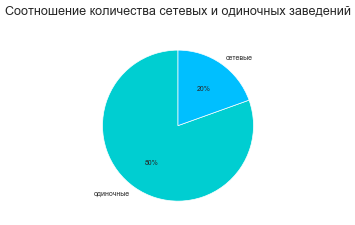

In [31]:
fig, ax = plt.subplots(figsize=(16,5), dpi=plot_dpi)

plt.pie(
        data.chain.value_counts(),
        startangle=90,
        autopct='%1.0f%%',
        colors=[color_sng, color_chn],
        labels=['одиночные', 'сетевые']
       )
ax.set_title('Соотношение количества сетевых и одиночных заведений', fontsize=18, pad=25)

space()
# plt.savefig('2. Соотношение количества сетевых и одиночных заведений.png', bbox_inches='tight')
plt.show()

>Сетевые заведения составляют 1/5 от общего количества. Можно сказать, что рынок децентрализован и высококонкурентен.  
Поскольку в целях исследования указано открытие коммерческого заведения, было бы полезно проанализировать долю сетевых заведений именно среди коммерческих.

<a id="id_2_3"></a>
### Преобладающий тип среди сетевых заведений

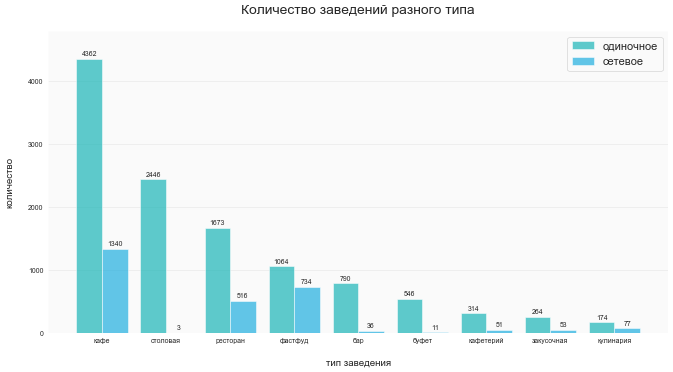


 примечание: график отсортирован по общему количеству заведений каждого типа






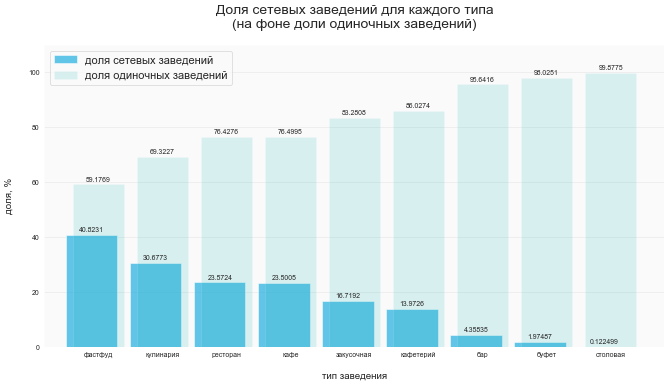

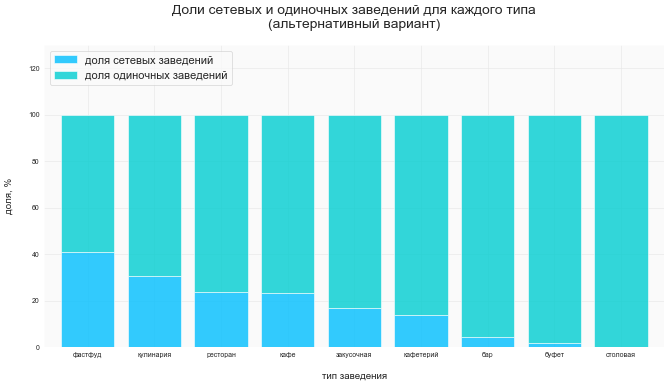

,net,net_percent
type,,
фастфуд,734,40.82
кулинария,77,30.68
ресторан,516,23.57
кафе,1340,23.50
закусочная,53,16.72
кафетерий,51,13.97
бар,36,4.36
буфет,11,1.97
столовая,3,0.12



 примечание: график и таблица отсортированы по размеру доли сетевых заведений каждого типа




In [32]:
# график количества заведений (в абсолютном выражении)

# подготовка данных

df = (
      data.groupby(['type', 'chain'])
          .id.count()
          .reset_index()
          .rename(columns={'id':'id_count'})
          .sort_values('id_count', ascending=False)
     )

sort_order = (                                           # сортировка графика по общему количеству заведений
              data.groupby(['type'])
              .id.count()
              .reset_index()
              .rename(columns={'id':'id_count'})
              .sort_values('id_count', ascending=False)
              .type
             )

# график

fig, ax = plt.subplots(figsize=(16,8), dpi=plot_dpi)

sns.barplot(
            data=df,
            x='type',
            y='id_count',
            hue='chain',
            order=sort_order,
            palette=[color_sng, color_chn],
            alpha=0.7
           )
ax.set_title('Количество заведений разного типа', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=14, labelpad=20)
ax.set_ylabel('количество', fontsize=14, labelpad=20)
ax.margins(0.05, 0.1)
ax.legend(fontsize=16)
bar_annotate(ax, 0)

space()
# plt.savefig('3.1. Количество заведений (в абсолютном выражении).png', bbox_inches='tight')
plt.show()

print('\n', 'примечание: график отсортирован по общему количеству заведений каждого типа')
space()


# --------------------------------------------------------------------------------------
# график доли сетевых заведений в зависимости от типа заведения (на фоне доли одиночных)

# подготовка данных

df = data.pivot_table(
                      index='type',
                      columns='chain',
                      values='id',
                      aggfunc={'count'}
                     )
df.columns = ['single', 'net']                                 # количество одиночных и сетевых соответственно
df['net_percent'] = df.net / (df.single + df.net) * 100        # процент сетевых
df['single_percent'] = df.single / (df.single + df.net) * 100  # процент одиночных
df = df.sort_values('single_percent').reset_index()


# график

fig, ax = plt.subplots(figsize=(16,8), dpi=plot_dpi)

sns.barplot(
            data=df,
            x='type',
            y='net_percent',
            palette=[color_chn],
            alpha=0.7,
            label='доля сетевых заведений'
           )

for patch in ax.patches:
    patch.set_x(patch.get_x() - 0.1)   # смещение для лучшего вида

sns.barplot(
            data=df,
            x='type',
            y='single_percent',
            palette=[color_sng],
            alpha=0.15,
            label='доля одиночных заведений'
           )

ax.set_title('Доля сетевых заведений для каждого типа' + '\n' + '(на фоне доли одиночных заведений)', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=14, labelpad=20)
ax.set_ylabel('доля, %', fontsize=14, labelpad=20)
ax.margins(0.05, 0.1)
ax.legend(fontsize=16, loc='upper left')
bar_annotate(ax, 1)

space()
# plt.savefig('3.2. Доля сетевых заведений для каждого типа (на фоне доли одиночных).png', bbox_inches='tight')
plt.show()


# ----------------------------------------------------------------------------
# альтернативный график доли сетевых заведений в зависимости от типа заведения

df_r = df.copy()
df_r = df_r.rename(columns={'net_percent':'доля сетевых заведений'})
df_r = df_r.rename(columns={'single_percent':'доля одиночных заведений'})

fig, ax = plt.subplots(figsize=(16,8), dpi=plot_dpi)

df_r[['type', 'доля сетевых заведений', 'доля одиночных заведений']].plot(ax=ax,
                                                                          kind='bar',
                                                                          stacked=True,
                                                                          x='type',
                                                                          rot=0,
                                                                          colors=[color_chn, color_sng],
                                                                          width=0.8,
                                                                          alpha=0.8
                                                                         )

ax.set_title('Доли сетевых и одиночных заведений для каждого типа'+'\n' +'(альтернативный вариант)', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=14, labelpad=20)
ax.set_ylabel('доля, %', fontsize=14, labelpad=20)
ax.margins(0.05, 0.3)
ax.legend(fontsize=16, loc='upper left')

space()
# plt.savefig('3.3. Доли сетевых и одиночных заведений для каждого типа.png', bbox_inches='tight')
plt.show()


# --------------------------------------------------------------------------------------
# таблица

display(
        df[['type', 'net', 'net_percent']]
        .set_index('type')
        .style.background_gradient('Blues', subset='net_percent', high=1)
        .format({'net_percent': '{:.2f}'})
       )

print('\n', 'примечание: график и таблица отсортированы по размеру доли сетевых заведений каждого типа')
space()

>Наибольшая доля сетевых заведений — среди фастфудов.  
Кулинария при небольшом количестве заведений имеет хорошую долю сетевых заведений.  
Наибольшая доля сетевых заведений там, где можно унифицировать оформление и  кухню, максимально снизив себестоимость.  
Практически отсутствуют сетевые столовые, очень маленькая доля сетевых буфетов и баров (формат более требователен к уникальности по сравнению с кафе).

<a id="id_2_4"></a>
### Характеристика сетевых заведений: много небольших заведений или мало, но больших?

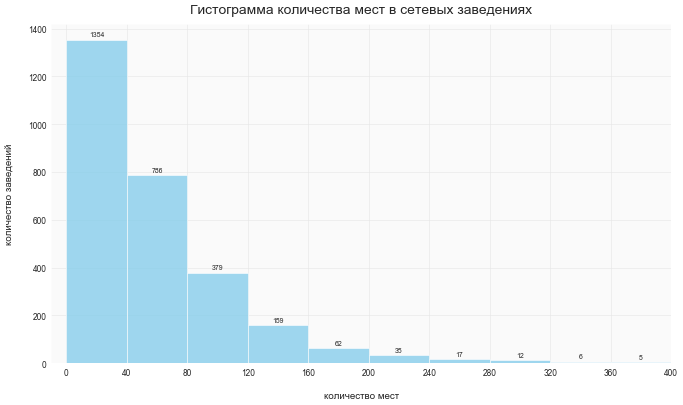

In [33]:
fig, ax = plt.subplots(figsize=(16,9), dpi=plot_dpi)

ax = (
      data
      .query('chain == "сетевое"')
      .seats
      .hist(bins=10, color=color_bsc, alpha=0.8, range=(0,400))
     )
ax.set_title('Гистограмма количества мест в сетевых заведениях', fontsize=20, pad=15)
ax.set_xlabel('количество мест', fontsize=14, labelpad=20)
ax.set_ylabel('количество заведений', fontsize=14, labelpad=20)
ax.set_xlim(-10,400)
ax.tick_params(labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
bar_annotate(ax, 0)

space()
# plt.savefig('4. Гистограмма количества мест в сетевых заведениях.png', bbox_inches='tight')
plt.show()

>Для сетевых заведений верно как утверждение "много заведений с небольшим числом посадочных мест в каждом", так и "мало заведений с большим количеством посадочных мест".

<a id="id_2_5"></a>
### Среднее количество посадочных мест для каждого типа заведения

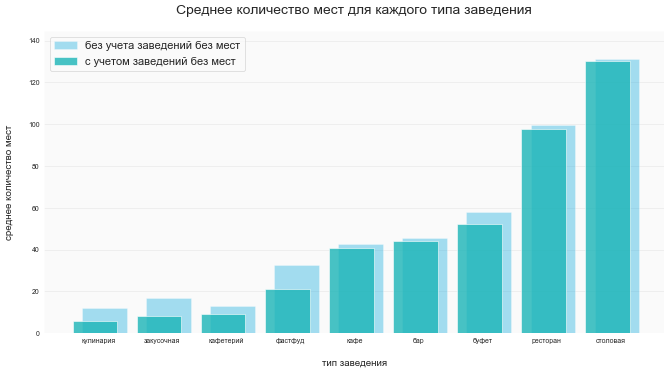

Среднее количество мест:


,c учетом заведений без мест,без учета заведений без мест
type,,
кулинария,6.0,12.1
закусочная,8.2,16.9
кафетерий,9.3,13.1
фастфуд,20.9,32.8
кафе,40.7,42.8
бар,43.9,45.4
буфет,52.1,58.1
ресторан,97.8,99.6
столовая,130.4,131.4





 примечание: графики и таблица отсортированы по среднему значению посадочных мест с учетом всех заведений





In [34]:
# подготовка данных

df_1 = (data
            .query('seats > 0')            # учитываются только заведения с посадочными местами
            .groupby('type')
            .agg({'seats':'mean'})
            .reset_index()
       )
df_2 = (data                              # учитываются все заведения, включая без посадочных мест
            .groupby('type')
            .agg({'seats':'mean'})
            .reset_index()
       )

# график среднего количества мест

fig, ax = plt.subplots(figsize=(16,8), dpi=plot_dpi)

sns.barplot(
            data=df_1,
            x='type',
            y='seats',
            palette=[color_chn],
            alpha=0.4,
            label='без учета заведений без мест',
            order=df_2.sort_values('seats').type    # порядок сортировки столбиков -
           )                                        # по возрастанию среднего значения по всем заведениям

for patch in ax.patches:
    patch.set_x(patch.get_x() + 0.15)   # смещение для лучшего вида
    
sns.barplot(
            data=df_2,
            x='type',
            y='seats',
            palette=[color_sng],
            alpha=0.8,
            label='c учетом заведений без мест',
            order=df_2.sort_values('seats').type    # порядок сортировки столбиков -
           )                                        # по возрастанию среднего значения по всем заведениям

for patch in ax.patches:
    patch.set_width(0.7)

ax.set_title('Среднее количество мест для каждого типа заведения', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=14, labelpad=20)
ax.set_ylabel('среднее количество мест', fontsize=14, labelpad=20)
ax.margins(0.05, 0.1)
ax.legend(loc='upper left', fontsize=16)

space()
# plt.savefig('5.1. Среднее количество мест для каждого типа заведения.png', bbox_inches='tight')
plt.show()


# таблица

print(font.BOLD + 'Среднее количество мест:' + font.END)
df = (
      pd.merge(df_2, df_1, on='type', suffixes=('_1', '_2'))
        .rename(columns={'seats_1':'c учетом заведений без мест','seats_2':'без учета заведений без мест'})
        .set_index('type')
        .sort_values('c учетом заведений без мест')
       )

display(df.style.background_gradient('Blues', subset='c учетом заведений без мест', high=1)
          .format('{:.1f}'))

space()
print('\n', 'примечание: графики и таблица отсортированы по среднему значению посадочных мест с учетом всех заведений')
space(2)

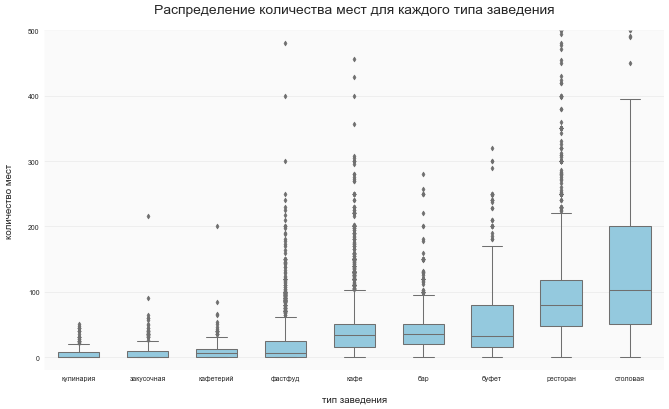

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
кулинария,251,6,10,0,0,0,8,50
закусочная,317,8,18,0,0,0,10,216
кафетерий,365,9,15,0,0,6,12,200
фастфуд,1798,21,39,0,0,6,25,580
кафе,5702,41,38,0,15,34,50,533
бар,826,44,68,0,20,35,50,1700
буфет,557,52,56,0,15,33,80,320
ресторан,2189,98,96,0,48,80,118,1500
столовая,2449,130,96,0,50,103,200,1400



 примечание: графики и таблица отсортированы по среднему значению посадочных мест


In [35]:
# график распределения количества мест

fig, ax = plt.subplots(figsize=(16,9), dpi=plot_dpi)

sns.boxplot(
            data=data,
            x='type',
            y='seats',
            palette=[color_bsc],
            width=0.6,
            order=df_2.sort_values('seats').type    # порядок сортировки "боксов" -
           )                                        # по возрастанию среднего значения по всем заведениям
                                                    # расчет df_2 - в предыдущей ячейке
ax.set_ylim(-20,500)
ax.set_title('Распределение количества мест для каждого типа заведения', fontsize=20, pad=25)
ax.set_xlabel('тип заведения', fontsize=14, labelpad=20)
ax.set_ylabel('количество мест', fontsize=14, labelpad=20)

space()
# plt.savefig('5.2. Распределение количества мест для каждого типа заведения.png', bbox_inches='tight')
plt.show()


# таблица

df = data.groupby('type').seats.describe().sort_values(by='mean')

display(df.style.background_gradient('Blues', subset='mean', high=1)
          .format('{:.0f}')
       )

print('\n', 'примечание: графики и таблица отсортированы по среднему значению посадочных мест')

>Столовая в среднем имеет наибольшее количество мест.  
>Для всех типов характерно смещение большей массы заведений к небольшому количеству мест (для конкретного типа) и длинный хвост заведений с аномально большим количеством мест.

<a id="id_2_6"></a>
### Топ-10 улиц по количеству заведений

In [36]:
# таблица топ-10 улиц

streets_top10 = (
                 data
                 .groupby(['street', 'area'])
                 .agg({'id':'count'})
                 .rename(columns={'id':'id_count'})
                 .sort_values('id_count', ascending=False)
                 .reset_index()
                 .head(10)
                )

space()
display_left(streets_top10)
space()

,street,area,id_count
0,проспект мира,| алексеевский район | ярославский район | район марьина роща | останкинский район | район ростокино | район свиблово | мещанский район |,203
1,профсоюзная улица,| академический район | район черемушки | район ясенево | район коньково | обручевский район | район теплый стан |,182
2,ленинградский проспект,| район аэропорт | район беговой | хорошевский район | район сокол |,172
3,пресненская набережная,| пресненский район |,167
4,варшавское шоссе,| район чертаново центральное | район чертаново северное | район чертаново южное | донской район | район нагатино-садовники | нагорный район | район северное бутово | район южное бутово |,162
5,ленинский проспект,| район проспект вернадского | район тропарево-никулино | донской район | район гагаринский | ломоносовский район | обручевский район | район теплый стан | район якиманка |,148
6,проспект вернадского,| район проспект вернадского | район раменки | район тропарево-никулино | район гагаринский | ломоносовский район |,128
7,кутузовский проспект,| район дорогомилово | район фили-давыдково |,114
8,каширское шоссе,| район москворечье-сабурово | район нагатино-садовники | район орехово-борисово южное | район орехово-борисово северное |,111
9,кировоградская улица,| район чертаново центральное | район чертаново северное | район чертаново южное |,108


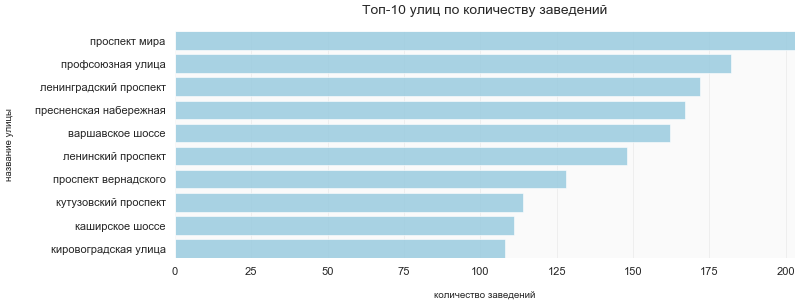

In [37]:
# график топ-10 улиц

fig, ax = plt.subplots(figsize=(16,6), dpi=plot_dpi)

sns.barplot(
            data=streets_top10,
            x='id_count',
            y='street',
            color=color_bsc,
            alpha=0.8
           )

ax.set_title('Топ-10 улиц по количеству заведений', fontsize=20, pad=25)
ax.set_xlabel('количество заведений', fontsize=14, labelpad=20)
ax.set_ylabel('название улицы', fontsize=14, labelpad=30)
ax.tick_params(labelsize=16, pad=10)
ax.margins(0.0, 0.0)

space()
# plt.savefig('6. Топ-10 улиц по количеству заведений.png', bbox_inches='tight')
plt.show()
space(2)

<a id="id_2_7"></a>
### Улицы с одним объектом общественного питания

In [38]:
streets_tail = (
                data
                .groupby(['street', 'area'])
                .agg({'id':'count'})
                .rename(columns={'id':'id_count'})
                .query('id_count == 1')
                .reset_index()    
                .sort_values('street')
               )
space()
print('Количество улиц с единственным заведением:', streets_tail.shape[0])
space()

display_left(streets_tail.sample(5))  # если следовать заданию, нужно вывести список полностью
space(2)



Количество улиц с единственным заведением: 539




,street,area,id_count
198,дмитровский переулок,| тверской район |,1
383,староалексеевская улица,| алексеевский район |,1
429,улица брусилова,| район южное бутово |,1
170,верхний золоторожский переулок,| район лефортово |,1
98,4-й кожевнический переулок,| даниловский район |,1


<a id="id_2_8a"></a>
### Распределение количества посадочных мест для топ-10 улиц по количеству заведений

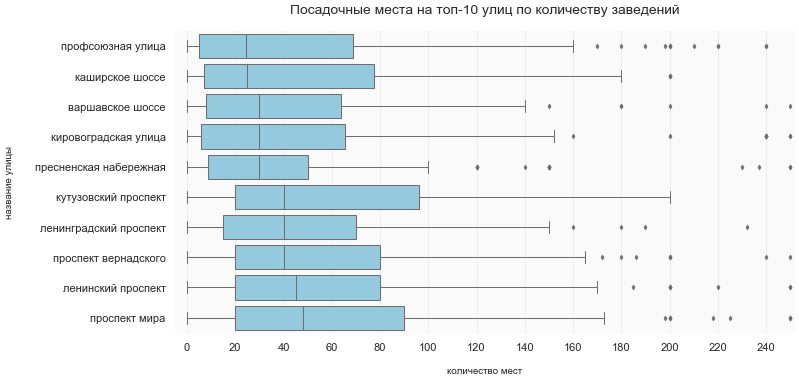

,count,mean,std,min,25%,50%,75%,max
street,,,,,,,,
профсоюзная улица,182,48,57,0,5,24,69,240
каширское шоссе,111,56,88,0,7,25,78,680
варшавское шоссе,162,53,75,0,8,30,64,500
кировоградская улица,108,60,79,0,6,30,66,300
пресненская набережная,167,46,65,0,8,30,50,478
кутузовский проспект,114,85,194,0,20,40,96,1700
ленинградский проспект,172,52,63,0,15,40,70,625
проспект вернадского,128,69,123,0,20,40,80,1288
ленинский проспект,148,63,68,0,20,45,80,495



 примечание: график и таблица отсортированы по медианному значению посадочных мест





In [39]:
# подготовка данных

data_top10 = data.query('street.isin(@streets_top10.street)')

# порядок сортировки по медианному количеству мест
box_order = (
             data_top10
             .groupby('street')
             .agg({'seats':'median'})
             .reset_index()
             .sort_values('seats')
             .street
            )

# (запасной) порядок сортировки по количеству заведений
# box_order = streets_top10.sort_values('id_count', ascending=False).street


# график

sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9'})

fig, ax = plt.subplots(figsize=(16,8), dpi=plot_dpi)

sns.boxplot(
            data=data_top10,
            x='seats',
            y='street',
            color=color_bsc,
            order=box_order
           )

ax.set_title('Посадочные места на топ-10 улиц по количеству заведений', fontsize=20, pad=25)
ax.set_xlabel('количество мест', fontsize=14, labelpad=20)
ax.set_ylabel('название улицы', fontsize=14, labelpad=30)
ax.tick_params(labelsize=16)
ax.set_xlim(-5,252)
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=16, pad=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

space()
# plt.savefig('8.1. Посадочные места на топ-10 улиц по количеству заведений.png', bbox_inches='tight')
plt.show()


# таблица

df = (
      data_top10.groupby('street')
                .seats.describe()
                .sort_values(by='50%')
     )

display(df.style.background_gradient('Blues', subset='50%', high=1)
          .format('{:.0f}')
       )

print('\n', 'примечание: график и таблица отсортированы по медианному значению посадочных мест')
space(2)

<a id="id_2_8b"></a>

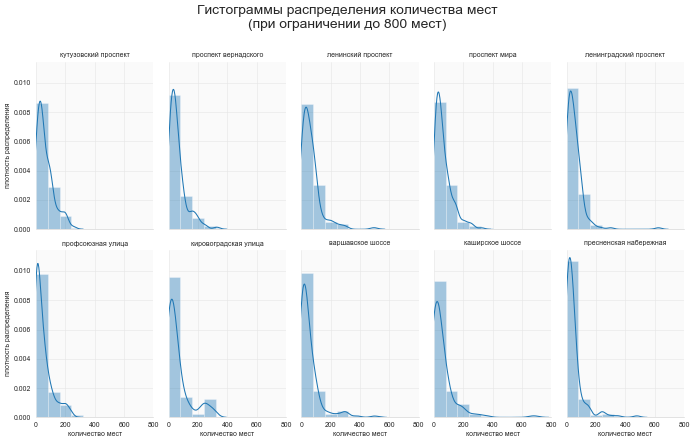

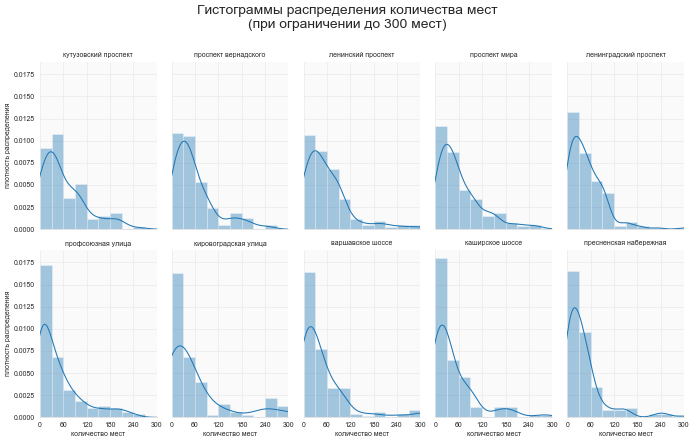

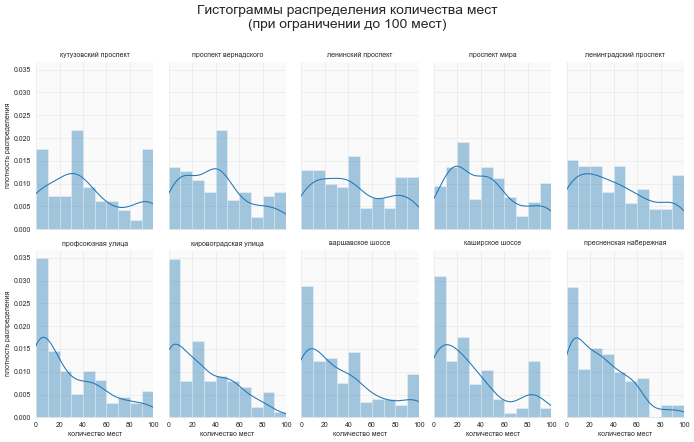

In [40]:
# гистограммы распределения количества мест в заведениях топ-10 улиц
# (среди топ-10 улиц по количеству заведений)

def hist_grid(df, max_seats, xticks_list):

    grid = (
            sns.FacetGrid(
                          data=df.query('seats <= @max_seats'),
                          col='street', col_wrap=5, xlim=(0,max_seats), height=4, aspect=0.7
                         )
               .map(
                    sns.distplot,
                    'seats',
                    bins=10,
                    hist_kws={'range':(0,max_seats)}
                   )
               .set_axis_labels('количество мест', 'плотность распределения')
               .set_titles(col_template="{col_name}")
               .set(xticks=xticks_list)
               .despine(left=True) 
           )

    grid.figure.dpi = plot_dpi
    grid.figure.suptitle('Гистограммы распределения количества мест' + '\n' +
                         f'(при ограничении до {max_seats} мест)',
                         fontsize=20, y=1.1)
    space()
#     plt.savefig(f'8.2. Гистограммы распределения количества мест (при ограничении до {max_seats} мест).png', bbox_inches='tight')
    plt.show()


hist_grid(data_top10, 800, [0,200,400,600,800])
hist_grid(data_top10, 300, [0,60,120,180,240,300])
hist_grid(data_top10, 100, [0,20,40,60,80,100])

In [41]:
# доля заведений с нулевым количеством мест

id_zero = data_top10.query('seats == 0').id.count()
id_total = data_top10.id.count()

space()
print('общая для топ-10 доля заведений с нулевым количеством мест: {:.1%}'.format(id_zero / id_total))


# количество и доля заведений с нулевым количеством мест в зависимости от типа

zero = (
             pd.merge(
                     data_top10.street.value_counts().reset_index(),
                     data_top10.query('seats == 0').street.value_counts().reset_index(),
                     on='index',
                     suffixes=('_t','_z')
                    )
              .rename(columns={'index':'street','street_t':'total','street_z':'zero'})
            )

zero['zero_%'] = zero['zero'] / zero['total']

display(
        zero.sort_values('zero_%')
            .set_index('street')
            .style.background_gradient('Blues', subset='zero_%', high=1)
            .format({'zero_%': '{:.2%}'})
       )



общая для топ-10 доля заведений с нулевым количеством мест: 10.8%


,total,zero,zero_%
street,,,
проспект вернадского,128,2,1.56%
проспект мира,203,11,5.42%
пресненская набережная,167,11,6.59%
ленинский проспект,148,10,6.76%
ленинградский проспект,172,13,7.56%
варшавское шоссе,162,21,12.96%
каширское шоссе,111,15,13.51%
кутузовский проспект,114,16,14.04%
кировоградская улица,108,23,21.30%


>1. В первой десятке улиц (по количеству заведений) прослеживается общая тенденция: небольших заведений (до 100 мест) существенно больше, чем крупных. 
>1. Для заведений до 80-100 мест наблюдается небольшое смещение в сторону меньшего количества мест, но в целом нет четко выраженной тенденции. Для отдельной улицы может преобладать тот или иной размер заведения, но возможно, это связано с имеющимися в наличии помещениями.
>1. Средняя доля заведений с нулевым количеством мест для улиц из топ-10 соотвествует средней доле по всему набору данных. Но внутри топ-10 есть существенные отличия: на некоторых улицах доля заведений с нулевым количеством мест существенно выше среднего значения. Предположительно, на этих улицах больше зон с общими посадочными местами (фудкортов).

## Вывод

### Краткий обзор проведенной работы

В данном исследовании были изучены данные из открытых источников о московских заведениях общественного питания. Оценено качество этих данных. Входные данные были проверены на пропуски, ошибки и дубликаты. Была проведена работа по улучшению качества входных данных: удаление дубликатов, удаление не относящихся к предмету исследования данных. Все замечания о входных данных приведены в [п.1.11](#id_1_11)

Даны рекомендации по результатам исследования. Определены потенциальные риски и возможности их устранения. Даны рекомендации по дальнейшему развитию исследования.

### Результаты анализа

1. Самый распространенный тип заведений - кафе. На их долю приходится почти 40% всех заведений. [п.2.1](#id_2_1)
1. Сетевые заведения составляют лишь 1/5 от общего количества. Рынок децентрализован и высококонкурентен. [п.2.2](#id_2_2)
1. Среди сетевых заведениий преобладает фастфуд. Сетевой фастфуд занимает 41% рынка. [п.2.3](#id_2_3)
1. Для сетевых заведений верно как утверждение "много заведений с небольшим числом посадочных мест в каждом", так и "мало заведений с большим количеством посадочных мест". [п.2.4](#id_2_4)
1. Наибольшее среднее количество мест в столовых — 130, следующий ресторан — 98. Среди заведений фастфуда около 1/3 не имеют собственных посадочных мест. Для всех типов заведений распределение количества мест характеризуется длинным хвостом высоких значений и большим стандартным отклонением. [п.2.5](#id_2_5)
1. В [п.2.6](#id_2_6) определена десятка улиц с наибольшим количеством заведений, а в [п.2.7](#id_2_7) — улицы с единственным заведением. Для всех улиц определены районы, через которые они проходят.
1. Заведения из первой десятки улиц были исследованы на количество посадочных мест как в целом ([п.2.8a](#id_2_8a)), так и отдельно для каждой улицы ([п.2.8b](#id_2_8b)). Большинство заведений имеют примерно до 80-100 мест. До этого количества распределение мест не имеет выраженной зависимости и скорее определяется размером имеющихся помещений. Для некоторых улиц характерно большое количество заведений без собственных мест. Вероятно, это обусловлено повышенной долей фудкортов на таких улицах.

### Риски и рекомендации

**Формулировка задания**

1. В задании сказано: `вы решили открыть небольшое кафе в Москве` и `дайте рекомендации о виде заведения`. Если уже решили, то странно давать рекомендации. Поэтому, переформулируем задачу так: **верно ли решение открыть небольшое кафе с официантами-роботами**.
1. В задании недостаточно подробно описана главная особенность будущего кафе: робот-официант. Вряд ли робота будут делать после исследования, следовательно, он уже существует. Не указана ключевая способность робота: он действительно способен полностью заменить официанта, или его основная функция — развлекательная. Знание особенностей робота пригодилось бы для более целенаправленного исследования.
1. Работоспособность робота зависит от плотности размещения посетителей, которая имеет технический предел. Сравнивать робокафе с традиционными напрямую по количеству мест некорректно, т.к. эти заведения могут существенно различаться по площади, а, следовательно, и расходам на помещение в пересчете на одного посетителя.
1. Отсутствует информация об экономической составляющей. Предположительно, для окупаемости робот должен обслуживать некое минимальное количество посетителей, что не только накладывает ограничения на минимальное количество мест, но также требует кратного масштабирования. И это далеко не все ограничения.
1. Зачем для открытия небольшого кафе с роботами понадобилось детально анализировать сетевые заведения? Между этими действиями — информационная пропасть: вряд ли информация о сетевых заведениях стоит на первом месте для принятия решения об открытии небольшого кибер-кафе.

Если коротко, **сформулированная цель не позволит дать ответ при имеющихся данных**.  Данное исследование можно рассматривать лишь как ограниченный анализ рынка заведений общественного питания.

---

**Рекомендации для кибер-кафе**

1. Тип заведения — кафе, поскольку в задании намекается, что робот предназначен именно для такого типа заведения.
1. Нужна улица с большим потоком посетителей, чтобы максимально долго использовать эффект новизны.
1. Можно ориентировать заведение на определенную аудиторию, например, на детей.
1. Шансы на успех можно повысить, если вместо самостоятельного заведения создать кафе при технопарке (или подобном большом комплексе) как часть большого аттракциона. В этом случае можно рассчитывать на синергетический эффект.
1. Рекомендацию о количестве мест на основе данного исследования дать невозможно: это зависит от "экономики" данного проекта, имеющихся в наличии помещений, а не от характеристик работающих заведений.
1. **Почему бы просто не запустить пилотный проект на базе действующего кафе? (или ресторана, фудкорта, рюмочной — зависит от предназначения робота)**

---

**Риски**

1. Рысплывчатая и поверхностная формулировка предполагаемого заведения и характеристик робота не позволяет определить верное направление исследования.
1. В данных из открытых источников предполагается много неточностей. Необходимо указание требуемой точности исследования для принятия решения об исправлении данных или поиске дополнительных источников информации.
1. При определении топ-10 улиц немаловажно учитывать длину улицы. Более показательной была бы плотность заведений на 1 км.
1. Утилитарные роботы рынку не нужны. Живые «роботы» сетевикам обходятся дешевле.

---

**Рекомендации для дальнейших исследований (в том числе обычных, не роботизированных заведений)**

1. Рекомендуется провести исследование с учетом размещения заведения в:
    - отдельном помещении;
    - общем помещении (ТРК) с собственным залом;
    - общем помещении (ТРК) с общим залом (фудкорт).
1. Рекомендуется учитывать такую характеристику, как площадь помещения или плотность размещения посетителей. Ввиду сложности получения такой информации массово, желательно сделать хотя бы выборочный анализ небольшого количества действующих заведений в сравнении с предполагаемым кибер-кафе.

## Ссылка на презентацию
https://disk.yandex.ru/i/mA5ZPgwGbgvbmA

## The End